In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Predict scores

In [ ]:
from pathlib import Path
import sys
import random
from concurrent.futures import ProcessPoolExecutor, wait, ThreadPoolExecutor

from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np

sys.path.append(Path().resolve().parent.as_posix())
from machina.predict import predict_by_flann


def process():
    scop_root = Scop(dir_path='../data/train', version='1.75')
    scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
    args = []
    for query in np.load('../data/test_domain_ids.npy'):
        for domain in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px'):
            if domain.sid in scop40 and query != domain.sid:
                args.append((query, domain.sid))
    random.shuffle(args)
    predict_by_flann('../data/train/scop40_logscore_tmscore0.5_window5_ratio0.1_x.npy',
                     '../data/train/scop40_logscore_tmscore0.5_window5_ratio0.1_y.npy',
                     '../data/train/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1',
                     1000,
                     '../data/prediction/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000',
                     '../data/train/pssm',
                     args)

with ProcessPoolExecutor(max_workers=6) as executor:
    wait([executor.submit(process) for _ in range(6)]) # 2 hour

,d1wlqc_,d2axtu1,d2pqrb1,d3cr3a1,d2jn6a1,d2zqna1,d1qg3a1,d2a5za1,d1wv3a1,d3etja1,...,d2axte1,d2axtd1,d2axtb1,d2axto1,d3dtub2,d2vy4a1,d3d9ta1,d2exfa1,d2ayja1,d3dplr1
count,180.000000,3.000000,26.000000,1.000000,101.000000,15.000000,96.000000,55.000000,15.000000,6.000000,...,1.000000,3.000000,1.000000,5.000000,3.000000,58.000000,4.000000,3.000000,9.000000,26.000000
mean,0.595455,0.756683,0.713536,0.832714,0.722425,0.852231,0.810739,0.619084,0.739672,0.683385,...,0.680296,0.787139,0.709832,0.519434,0.742337,0.703097,0.943327,0.751158,0.606152,0.694502
std,0.043751,0.067659,0.065962,NaN,0.075021,0.043414,0.068887,0.040759,0.036511,0.070635,...,NaN,0.010308,NaN,0.042518,0.075014,0.083692,0.038127,0.118204,0.074905,0.082089
min,0.471214,0.678779,0.592453,0.832714,0.448483,0.769255,0.637446,0.495915,0.691455,0.583582,...,0.680296,0.777569,0.709832,0.455405,0.681608,0.501125,0.898113,0.637207,0.461921,0.509061
25%,0.572151,0.734658,0.674559,0.832714,0.679810,0.821974,0.772804,0.595198,0.708158,0.647962,...,0.680296,0.781682,0.709832,0.506909,0.700410,0.648472,0.919503,0.690137,0.568449,0.642147
50%,0.594667,0.790538,0.715088,0.832714,0.725311,0.873846,0.830748,0.627441,0.734420,0.684106,...,0.680296,0.785796,0.709832,0.524245,0.719212,0.708519,0.946557,0.743066,0.605958,0.709955
75%,0.622352,0.795635,0.767937,0.832714,0.770384,0.880370,0.859011,0.646115,0.764851,0.713208,...,0.680296,0.791925,0.709832,0.541560,0.772702,0.771579,0.970381,0.808133,0.670939,0.749760
max,0.720330,0.800733,0.845628,0.832714,0.885431,0.903522,0.923138,0.708392,0.820036,0.789691,...,0.680296,0.798054,0.709832,0.569050,0.826191,0.840881,0.982083,0.873200,0.693398,0.822620


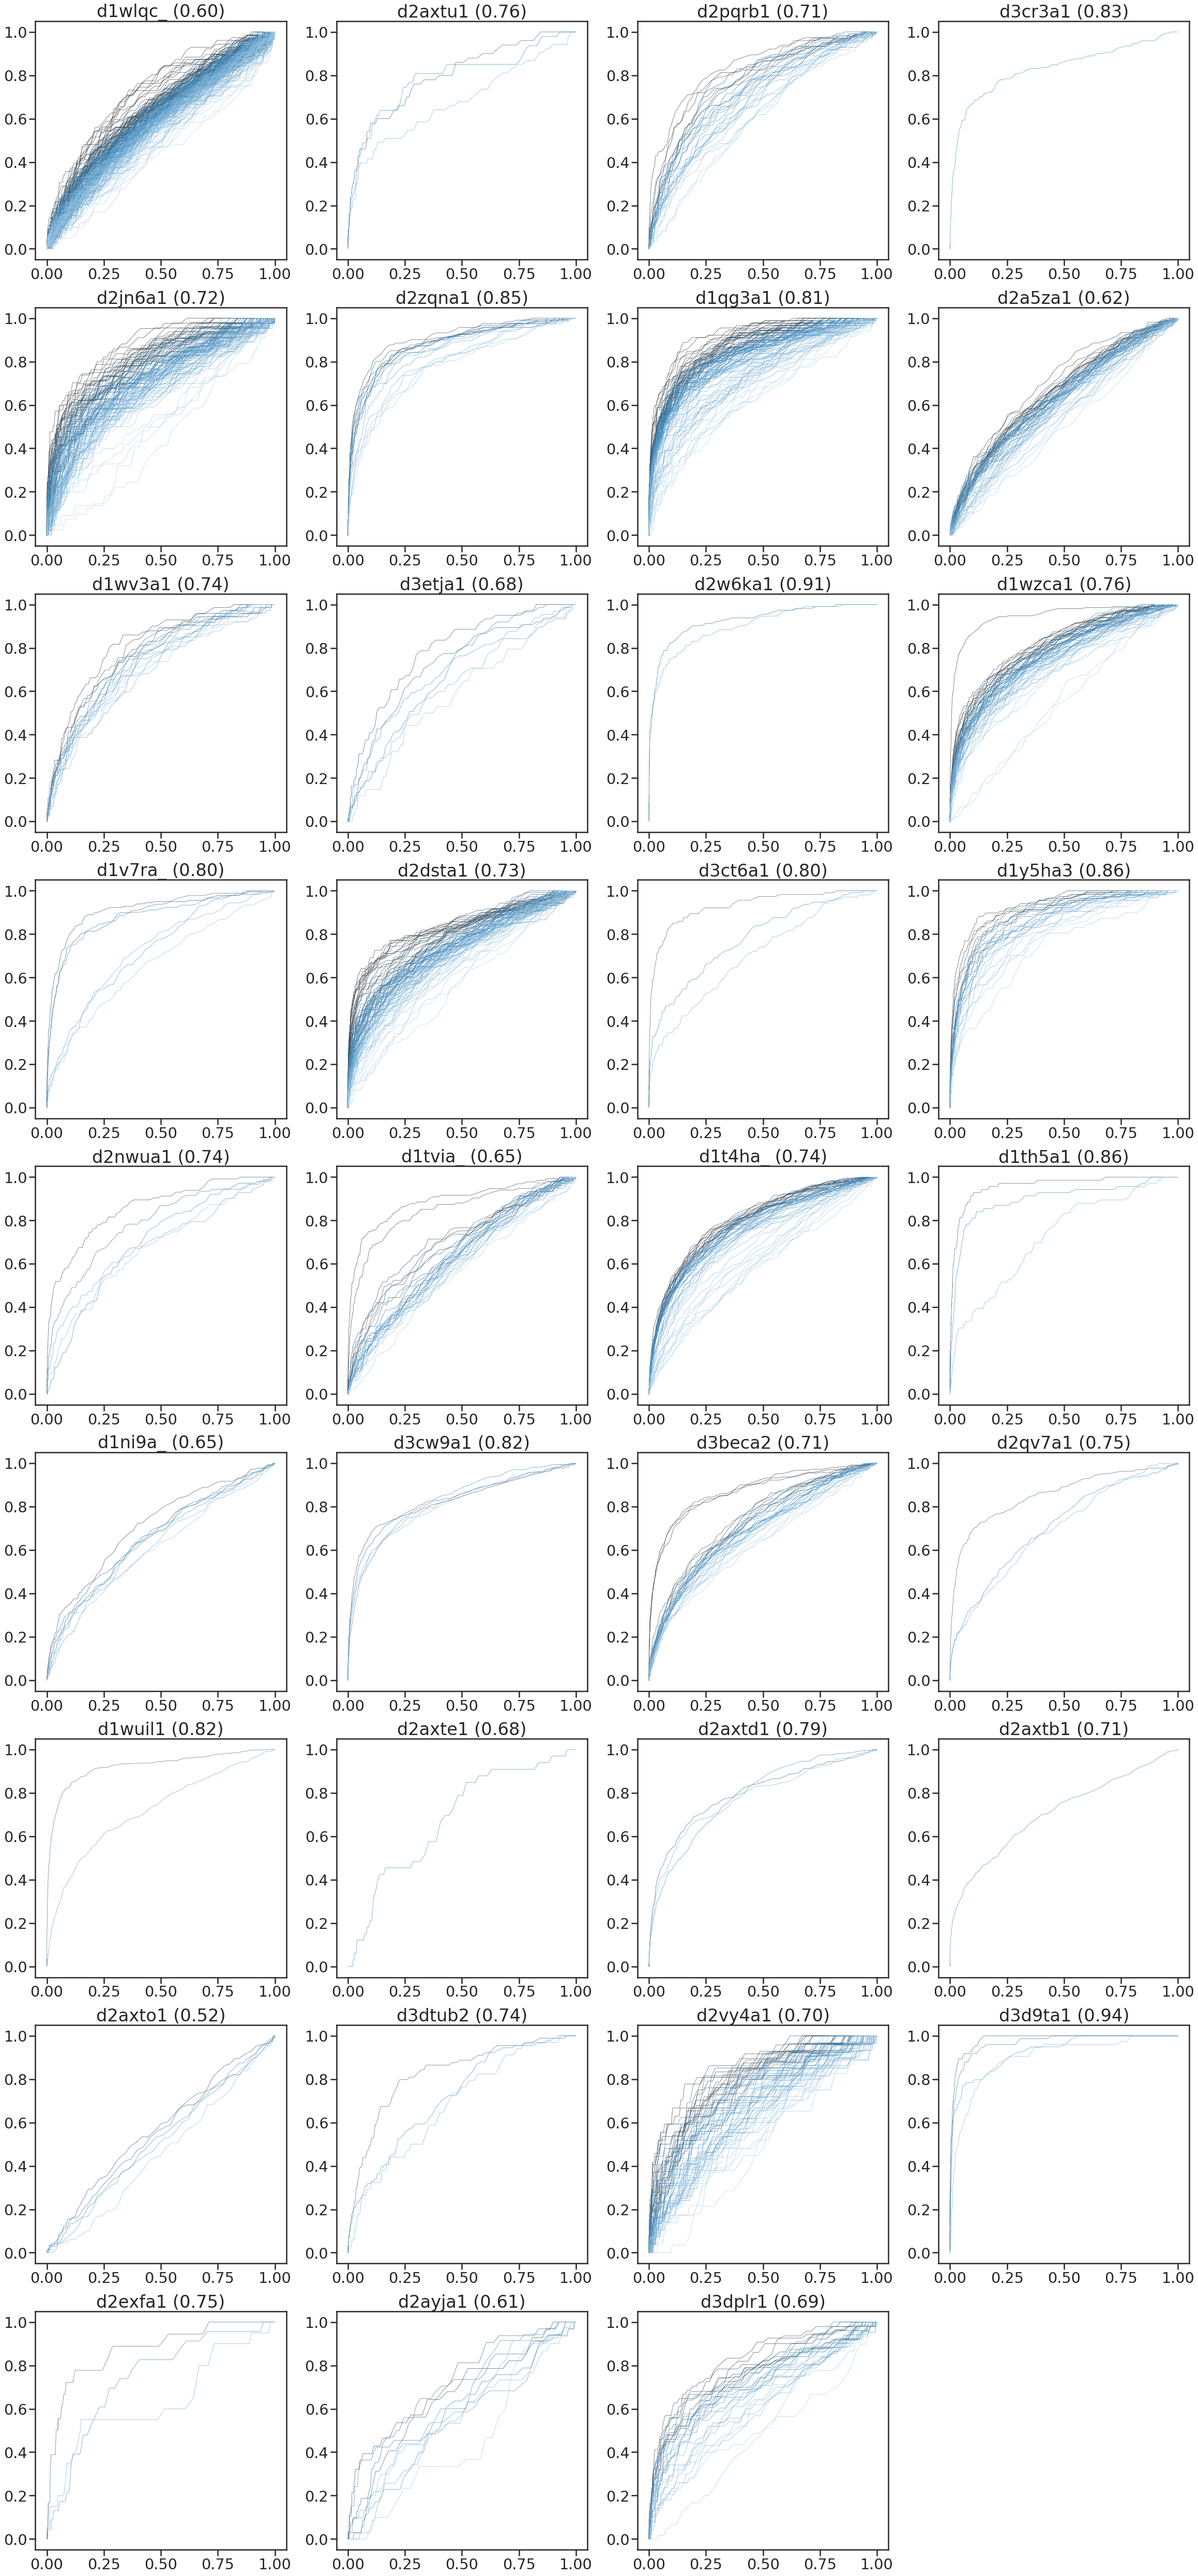

In [13]:
from pathlib import Path
import sys

from tqdm import tqdm_notebook as tqdm
from Bio.SCOP import Scop
from Bio import SeqIO
import numpy as np
from sklearn import metrics
from matplotlib import pyplot
import seaborn
import pandas
from IPython.display import display

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_training_dataset import get_validation_label

scop_root = Scop(dir_path='../data/train', version='1.75')
test_domain = np.load('../data/test_domain_ids.npy')
scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
structural_alignments = SeqIO.index('../data/train/scop40_structural_alignment.fasta', 'fasta')

# Get ROC and calculate AUC
auc_d = {}
roc_d = {}
for query in tqdm(test_domain):
    auc_d[query] = []
    roc_d[query] = {}
    roc_d[query]['fpr'] = []
    roc_d[query]['tpr'] = []
    roc_d[query]['index'] = []
    i = 0
    for domain in [_.sid for _ in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px')]:
        if domain not in scop40:
            continue
        if domain == query:
            continue
        test = get_validation_label(query, domain, structural_alignments, '../data/train/pssm').flatten()
        pred = np.load(f'../data/prediction/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000/{query}/{domain}.npy').flatten()
        assert test.shape[0] == pred.shape[0]
        fpr, tpr, _ = metrics.roc_curve(test, pred)
        auc_d[query].append(metrics.auc(fpr, tpr))
        roc_d[query]['fpr'].extend(fpr)
        roc_d[query]['tpr'].extend(tpr)
        roc_d[query]['index'].extend([i]*len(fpr))
        i += 1

auc_df = pandas.DataFrame.from_dict(auc_d, orient='index')
auc_df = auc_df.transpose()
display(auc_df.describe())

# Visualize
fig, axes = pyplot.subplots(9, 4, figsize=(40, 90))
seaborn.set(style='ticks')
seaborn.set_context('poster', 1.4, rc={'xticks.size': 30.0})

i = 0
for query in tqdm(test_domain):
    roc_df = pandas.DataFrame.from_dict(roc_d[query])
    seaborn.lineplot(x='fpr', y='tpr', data=roc_df, hue='index', linewidth=.6,
                     palette=seaborn.color_palette('Blues_d', len(auc_d[query])),
                     hue_order=sorted(range(len(auc_d[query])), key=lambda _: auc_d[query][_], reverse=True),
                     ax=axes[int(i/4), i%4], legend=False)
    avgauc = auc_df[query].mean()
    axes[int(i/4), i%4].set_title(f'{query} ({avgauc:.2f})')
    axes[int(i/4), i%4].set_xlabel('')
    axes[int(i/4), i%4].set_ylabel('')
    i += 1
axes[8, 3].set_axis_off()
fig.savefig('roc_label_prediction.pdf', bbox_inches='tight', pad_inches = 0)

## Generate alignment

In [2]:
from pathlib import Path
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed

from tqdm import tqdm_notebook as tqdm
import numpy as np
from Bio.SCOP import Scop
from Bio import SeqIO

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_alignment import alignment_local

test_domain = np.load('../data/test_domain_ids.npy')
scop_root = Scop(dir_path='../data/train', version='1.75')
scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
GAP_OPEN = -0.1
GAP_EXTEND = -0.0001

for query in tqdm(test_domain):
    result_dir = Path(
        f'../data/results/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000_open{-GAP_OPEN}_extend{-GAP_EXTEND}/{query}')
    result_dir.mkdir(exist_ok=True, parents=True)
    with ProcessPoolExecutor() as executor:
        futures = []
        for domain in [_.sid for _ in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px')]:
            if domain not in scop40 or domain == query:
                continue
            futures.append(
                executor.submit(alignment_local,
                                f'../data/prediction/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000/{query}/{domain}.npy',
                                query, domain, '../data/train/pssm', GAP_OPEN, GAP_EXTEND))
        for future in as_completed(futures):
            key, ali = future.result()
            np.save(result_dir/f'{key[1]}.npy', np.array(ali)) # 9 min

In [3]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import os
import sys
from concurrent.futures import ThreadPoolExecutor, as_completed

from tqdm import tqdm_notebook as tqdm
import numpy as np
from Bio.SCOP import Scop
from Bio import SeqIO

sys.path.append(Path().resolve().parent.as_posix())
from machina.generate_models import MachinaModel

scop_root = Scop(dir_path='../data/train', version='1.75')
test_domain = np.load('../data/test_domain_ids.npy')
scop40 = SeqIO.index('../data/train/astral-scopdom-seqres-gd-sel-gs-bib-40-1.75.fa', 'fasta')
GAP_OPEN = -0.1
GAP_EXTEND = -0.0001


def _process(args):
    for a in args:
        MachinaModel().generate_protein_model(a[0], a[1], a[2], a[3], a[4])


with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = []
    for query in test_domain:
        domains = [_.sid for _ in scop_root.getDomainBySid(query).getAscendent('sf').getDescendents('px')
                   if _.sid in scop40 and _.sid != query]
        args = [
            (query, _,
             f'../data/results/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000_open{-GAP_OPEN}_extend{-GAP_EXTEND}/{query}/{_}.npy',
             f'../data/results/flann19_scop40_logscore_tmscore0.5_window5_ratio0.1_nn1000_open{-GAP_OPEN}_extend{-GAP_EXTEND}/{query}',
             f'../data/train/pdbstyle-1.75/{_[2:4]}')
            for _ in domains]
        futures.append(executor.submit(_process, args))
    [_ for _ in tqdm(as_completed(futures), total=len(futures))] # 20 min

# SCOP40内を検索してTop10でモデルを作成

** sequence independent**

* PSI-BLASTはUniref90でプロファイルを作成し、それをクエリとして使用
* DELTA-BLASTはCDDを検索してプロファイルを作るので、クエリはプロファイルではなく配列
* HHsearchはUniclust30でA3Mを作成し、それをクエリにしている
    * 独自のSCOP40 DBが検索対象
    * 2つのテストクエリで検索結果がゼロとなる場合が出てしまっている

In [1]:
from pathlib import Path
import os
from concurrent.futures import ThreadPoolExecutor,wait

import numpy as np

from machina.generate_models import MachinaModel

test_data = np.load('data/test/scop40.npy')
model_name = 'flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.01_nn1000'


def _process(args):
    MachinaModel().generate_protein_models_from_search(args[0], args[1], args[2])


with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    futures = []
    for query in test_data:
        args = (f'results/search/{model_name}/{query}_open0.1_extend0.01.npy', query, f'results/search/{model_name}/top10/{query}')
        futures.append(executor.submit(_process, args))
    wait(futures)

/home/makigaki/.local/lib/python3.6/site-packages/Bio/SeqIO/PdbIO.py:218: BiopythonWarning: Ignoring out-of-order residues after a gap
  BiopythonWarning)


100%|██████████| 14/14 [00:53<00:00,  3.48s/it]


,PSI-BLAST,DELTA-BLAST,HHsearch,Proposed
count,134.000000,129.000000,125.000000,140.000000
mean,0.389850,0.416860,0.320923,0.475595
std,0.295574,0.289724,0.259199,0.253834
min,0.029230,0.029230,0.029860,0.119160
25%,0.114452,0.147700,0.099060,0.261755
50%,0.267520,0.271880,0.238450,0.312485
75%,0.711883,0.740580,0.534450,0.754305
max,0.927300,0.905620,0.834030,0.934810


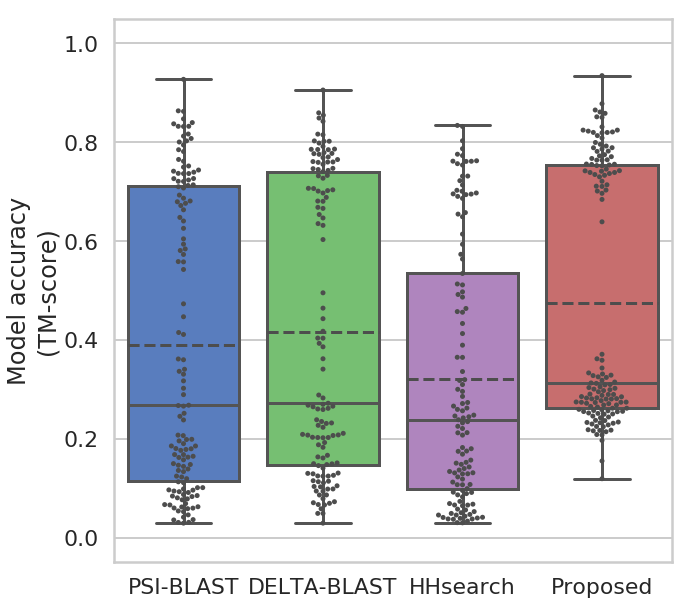

In [3]:
%matplotlib inline

from datetime import datetime
from pathlib import Path

from IPython.display import display
from tqdm import tqdm
from matplotlib import pyplot
import seaborn as sns
import pandas as pd

from machina.TMtoolsCommandLine import TMalignCommandLine

pal = sns.color_palette([
    (0.2823529411764706, 0.47058823529411764, 0.8117647058823529), # PSI
    (0.41568627450980394, 0.8, 0.396078431372549), # DELTA
    (0.7058823529411765, 0.48627450980392156, 0.7803921568627451), # HH
    #(0.4666666666666667, 0.7450980392156863, 0.8588235294117647), # SW
    (0.8392156862745098, 0.37254901960784315, 0.37254901960784315), # Pro
    #(0.7686274509803922, 0.6784313725490196, 0.4), # TM
])
test_data = np.load('data/test/scop40.npy')
top = 10
result_d = {}

for query_sid in tqdm(test_data):
    key = 'PSI-BLAST'
    if key not in result_d:
        result_d[key] = []
    for pdb_file in Path(f'data/.psiblast_pssm_iter1_top{top}/{query_sid}').glob('*.pdb'):
        if query_sid in pdb_file.stem:
            continue
        tmalign = TMalignCommandLine(pdb_file, f'data/scop_e/{query_sid[2:4]}/{query_sid}.ent')
        tmalign.run()
        if tmalign.tmscore is None:
            continue
        score = tmalign.tmscore[1]
        result_d[key].append(score)
    key = 'DELTA-BLAST'
    if key not in result_d:
        result_d[key] = []
    for pdb_file in Path(f'data/.deltablast_iter1_top{top}/{query_sid}').glob('*.pdb'):
        if query_sid in pdb_file.stem:
            continue
        tmalign = TMalignCommandLine(pdb_file, f'data/scop_e/{query_sid[2:4]}/{query_sid}.ent')
        tmalign.run()
        if tmalign.tmscore is None:
            continue
        score = tmalign.tmscore[1]
        result_d[key].append(score)
    key = 'HHsearch'
    if key not in result_d:
        result_d[key] = []
    for pdb_file in Path(f'data/.hhsearch/{query_sid}/top{top}_global_aln').glob('*.pdb'):
        if query_sid in pdb_file.stem:
            continue
        tmalign = TMalignCommandLine(pdb_file, f'data/scop_e/{query_sid[2:4]}/{query_sid}.ent')
        tmalign.run()
        if tmalign.tmscore is None:
            tmalign = TMalignCommandLine(pdb_file, f'data/scop_e_all/{query_sid[2:4]}/{query_sid}.ent')
            tmalign.run()            
        if tmalign.tmscore is None:
            continue
        score = tmalign.tmscore[1]
        result_d[key].append(score)
    model_name = 'flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.01_nn1000'
    key = 'Proposed'
    if key not in result_d:
        result_d[key] = []
    for pdb_file in Path(f'results/search/{model_name}/top{top}/{query_sid}').glob('*.pdb'):
        if query_sid in pdb_file.stem:
            continue
        tmalign = TMalignCommandLine(pdb_file, f'data/scop_e/{query_sid[2:4]}/{query_sid}.ent')
        tmalign.run()
        result_d[key].append(tmalign.tmscore[1])


result_df = pd.DataFrame.from_dict(result_d, orient='index')
result_df = result_df.transpose()
display(result_df.describe())

sns.set_style('whitegrid')
sns.set_context('poster')
fig, ax = pyplot.subplots(figsize=(10, 10))
ax.set_ylabel(f'Model accuracy\n(TM-score)')
ax.set_ylim(bottom=-0.05, top=1.05)
bp = sns.boxplot(data=result_df, ax=ax, showmeans=True, meanline=True,
                 palette=pal, meanprops={'color': '.3', 'linewidth': 3},
                 flierprops={'markersize': 8, 'marker': 'x', 'markerfacecolor': '.3', 'markeredgewidth': 1.3})
sns.swarmplot(data=result_df, ax=ax, color='.3', size=5, linewidth=0)
fig.savefig(Path('~/boxplot_search_top10_tmscore.pdf').expanduser(), bbox_inches='tight', pad_inches = 0)

# Homology Detect ROC

AUROCのBoxplot

,PSI-BLAST,DELTA-BLAST,HHsearch,Proposed
count,14.000000,14.000000,12.000000,14.000000
mean,0.434898,0.490698,0.690398,0.325759
std,0.372122,0.368614,0.364398,0.347073
min,0.000000,0.000000,0.006364,0.000000
25%,0.133095,0.199245,0.424412,0.000000
50%,0.277761,0.492727,0.867747,0.255556
75%,0.742826,0.765507,0.976250,0.580000
max,0.966667,0.966667,0.980000,0.952500


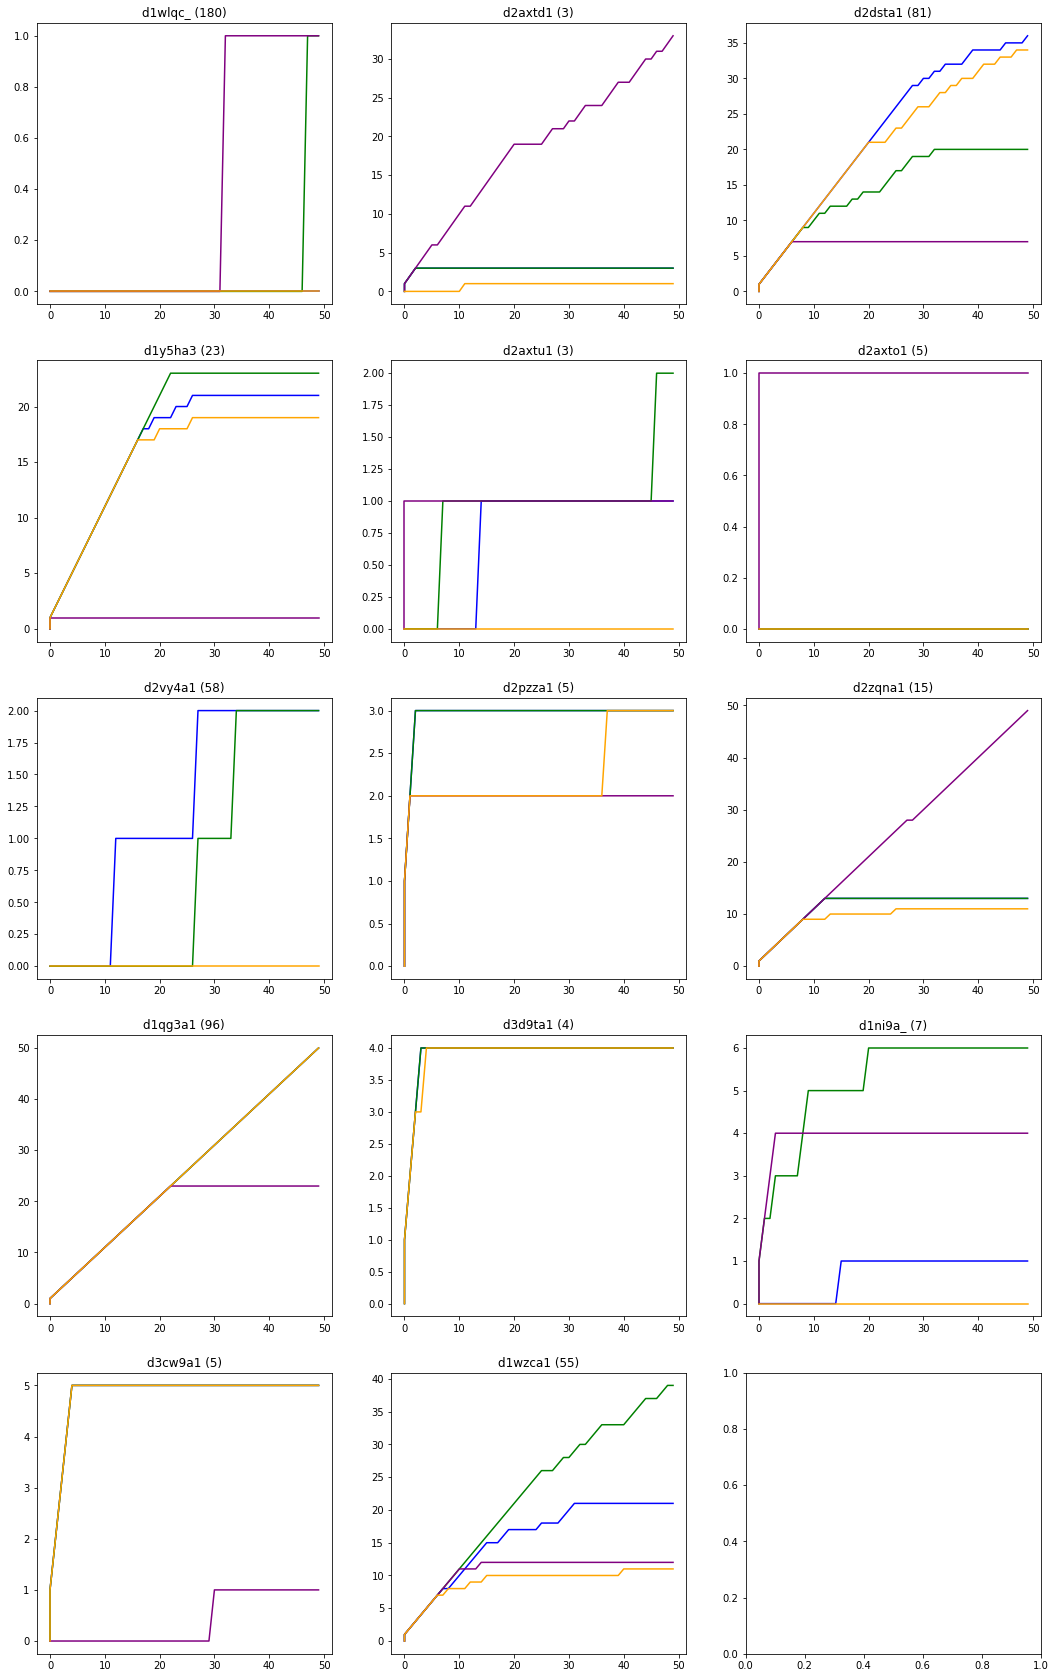

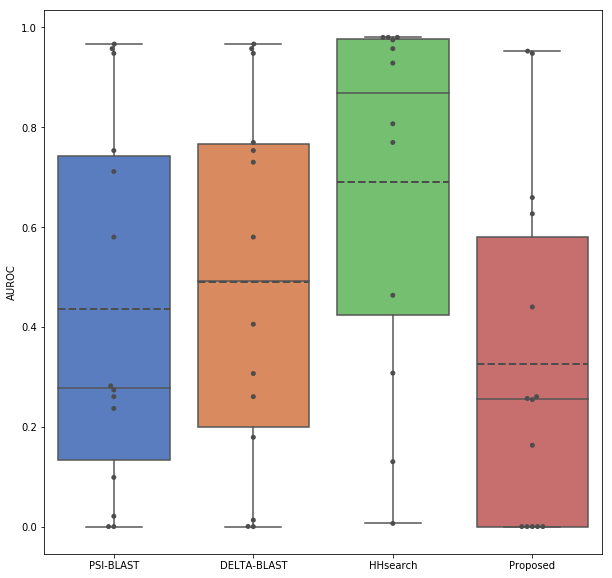

In [3]:
%matplotlib inline

import pickle
from pathlib import Path
from datetime import datetime

import numpy as np
from Bio import SearchIO
from Bio.SCOP import Scop
from sklearn import metrics
from pandas import DataFrame
from matplotlib import pyplot
import seaborn as sns
from tqdm import tqdm
from IPython.display import display

scop100 = Scop(dir_path='data/scop', version='1.75')
scop40_hie = pickle.load(Path('data/train/scop40_hie.pkl').open('rb'))
fp_limit = 50
test_data = np.load('data/test/scop40.npy')
auc_d = {}
fig, axes = pyplot.subplots(nrows=5, ncols=3, figsize=(18, 30))


def blast(blast_dir, color, key):
    auc_d[key] = []
    n = 0
    for query_sid in test_data:
        results = SearchIO.parse(f'{blast_dir}/{query_sid}.xml', 'blast-xml')
        results = list(list(results)[-1])  # consider only the final iteration
        query_sf_sccs = scop100.getDomainBySid(query_sid).getAscendent('sf').sccs
        all_tp_count = len(scop40_hie[scop100.getDomainBySid(query_sid).getAscendent('sf').sunid])
        roc_score, roc_label = [], []
        for hit in results:
            tmpl_sf_sccs = '.'.join(hit.description.split(' ')[0].split('.')[:-1])
            roc_score.append(hit.hsps[0].evalue)
            label = 1 if query_sf_sccs == tmpl_sf_sccs else 0
            roc_label.append(label)
            if roc_label.count(0) == fp_limit:
                break
        fpc, tpc = [0], [0]
        for i in range(0, fp_limit):
            fpc.append(i)
            tpc.append(roc_label[:i+1].count(1))
        auc = metrics.auc(fpc, tpc) / fp_limit / all_tp_count
        auc_d[key].append(auc)
        axes[n%5, n%3].plot(fpc, tpc, color=color)
        axes[n%5, n%3].set_title(f'{query_sid} ({all_tp_count})')
        n += 1

        
def machina(model_name):
    def _max_score(_x):
        return max(list(_x.values())[0], key=lambda __x: __x[2])[2]
    auc_d['Proposed'] = []
    n = 0
    for query_sid in test_data:
        result = np.load(f'results/search/{model_name}/{query_sid}_open0.1_extend0.01.npy')
        rank = sorted(result.tolist(), key=_max_score, reverse=True)
        rank = [{list(x.keys())[0]: list(x.values())[0]} for x in rank]
        roc_score, roc_label = [], []
        all_tp_count = 0
        for r in rank:
            tid = list(r.keys())[0]
            qdom, tdom = scop100.getDomainBySid(query_sid), scop100.getDomainBySid(tid)
            qsccs, tsccs = qdom.getAscendent('sf').sccs, tdom.getAscendent('sf').sccs
            all_tp_count = len(scop40_hie[qdom.getAscendent('sf').sunid])
            score = r[tid][0][2]
            roc_score.append(score)
            label = 1 if qsccs == tsccs else 0
            roc_label.append(label)
            if roc_label.count(0) == fp_limit:
                break
        fpc, tpc = [0], [0]
        for i in range(0, fp_limit):
            fpc.append(i)
            tpc.append(roc_label[:i+1].count(1))
        auc = metrics.auc(fpc, tpc) / fp_limit / all_tp_count
        auc_d['Proposed'].append(auc)
        axes[n%5, n%3].plot(fpc, tpc, color='orange')
        axes[n%5, n%3].set_title(f'{query_sid} ({all_tp_count})')
        n += 1

def hhsearch(hhsearch_dir, db_dir, color, key):
    test_data = {
     'd1wlqc_': (datetime(2009, 2, 17, 0, 0), 'a.4.5', 762),
     'd2axtu1': (datetime(2009, 2, 10, 0, 0), 'a.60.12', 159),
     'd2zqna1': (datetime(2009, 2, 10, 0, 0), 'b.42.2', 119),
     'd1qg3a1': (datetime(2009, 1, 20, 0, 0), 'b.1.2', 344),
     'd1wzca1': (datetime(2009, 1, 27, 0, 0), 'c.108.1', 296),
     'd2dsta1': (datetime(2009, 1, 27, 0, 0), 'c.69.1', 975),
     'd1y5ha3': (datetime(2009, 2, 10, 0, 0), 'd.37.1', 62),
     'd2pzza1': (datetime(2009, 1, 20, 0, 0), 'd.77.1', 92),
     'd1ni9a_': (datetime(2009, 2, 10, 0, 0), 'e.7.1', 151),
     'd3cw9a1': (datetime(2008, 9, 2, 0, 0), 'e.23.1', 22),
     'd2axtd1': (datetime(2009, 2, 10, 0, 0), 'f.26.1', 174),
     'd2axto1': (datetime(2009, 2, 10, 0, 0), 'f.4.1', 15),
     'd2vy4a1': (datetime(2009, 2, 17, 0, 0), 'g.37.1', 182),
     'd3d9ta1': (datetime(2009, 2, 10, 0, 0), 'g.52.1', 81)
    }
    hie_d = {}
    for line in [_ for _ in Path(f'{db_dir}/scop40_hhm.ffdata').read_text().splitlines() if _.startswith('NAME ')]:
        dsid = line.split()[1]
        sf_sccs = '.'.join(line.split()[2].split('.')[:3])
        if sf_sccs not in hie_d:
            hie_d[sf_sccs] = [dsid]
        else:
            hie_d[sf_sccs].append(dsid)
    auc_d[key] = []
    n = 0
    for query_sid in test_data:
        qsccs = test_data[query_sid][1]
        if qsccs in hie_d:
            all_tp_count = len(hie_d[qsccs])
        else:
            continue
        raw_lines = Path(f'{hhsearch_dir}/{query_sid}/{query_sid}.hhr').read_text().splitlines()
        result_points = [i for i, l in enumerate(raw_lines) if l.startswith('No ')]
        roc_label = []
        already = []
        for i, _ in enumerate(result_points):
            if i == len(result_points)-1:
                lines = raw_lines[result_points[i]:]
            else:
                lines = raw_lines[result_points[i]:result_points[i+1]]
            tsid = lines[1].split()[0]
            if tsid in already:
                continue
            else:
                already.append(tsid)
            tsccs = '.'.join(lines[1].split()[1].split('.')[:-1])
            label = 1 if qsccs == tsccs else 0
            roc_label.append(label)
            if roc_label.count(0) == fp_limit:
                break
        fpc, tpc = [0], [0]
        for i in range(0, fp_limit):
            fpc.append(i)
            tpc.append(roc_label[:i+1].count(1))
        auc = metrics.auc(fpc, tpc) / fp_limit / all_tp_count
        auc_d[key].append(auc)
        axes[n%5, n%3].plot(fpc, tpc, color=color)
        axes[n%5, n%3].set_title(f'{query_sid} ({all_tp_count})')
        n +=1 

blast('data/.psiblast_pssm_iter1', 'blue', 'PSI-BLAST')
blast('data/.deltablast_iter1', 'green', 'DELTA-BLAST')
hhsearch('data/.hhsearch', '/data/DB/hhsuitedb', 'purple', 'HHsearch')
machina('flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.01_nn1000')
auc_df = DataFrame.from_dict(auc_d, orient='index').transpose()
display(auc_df.describe())
fig2, ax2 = pyplot.subplots(figsize=(10, 10))
# sns.set_style('whitegrid')
# sns.set_context('talk')
ax2.set_ylabel(f'AUROC')
sns.boxplot(data=auc_df, palette='muted', showmeans=True, meanline=True, ax=ax2, meanprops={'color': '.3', 'linewidth': 2})
sns.swarmplot(data=auc_df, ax=ax2, color='.3', size=5, linewidth=0)
fig2.savefig(Path('~/boxplot_search_auroc.pdf').expanduser())

In [ ]:
def parse():
    raw_lines = Path(f'{hhsearch_dir}/{query_sid}/{query_sid}.hhr').read_text().splitlines()
    result_points = [i for i, l in enumerate(raw_lines) if l.startswith('No ')]
    search_result = {}
    search_result['hits'] = []
    for i, _ in enumerate(result_points):
        if i == len(result_points)-1:
            lines = raw_lines[result_points[i]:]
        else:
            lines = raw_lines[result_points[i]:result_points[i+1]]
        aln_lines = [l for l in lines if l.startswith('Q ') and 'Consensus' not in l]
        qseq = SeqRecord(Seq(''.join([l.split()[3] for l in aln_lines]), generic_protein),
                         id=search_result['query']['id'], name=search_result['query']['id'],
                         description='query')
        tmpl_id = lines[1].split()[0][1:]
        tmpl_desc = lines[1][lines[1].find(' ')+1:]
        aln_lines = [l for l in lines if l.startswith('T ') and 'Consensus' not in l]
        tseq = SeqRecord(Seq(''.join([l.split()[3] for l in aln_lines]), generic_protein),
                         id=tmpl_id, name=tmpl_id, description=tmpl_desc)
        search_result['hits'].append(MultipleSeqAlignment([qseq, tseq]))


(query, template, proposed, hhsearch, diff, structural_aln)の順

https://www.rcsb.org/3d-view/1WZC 
('d1wzca1', 'd1y8aa1', 0.52444, 0.48553, 0.03891, 0.57915)

https://www.rcsb.org/3d-view/1QG3
('d1qg3a1', 'd1va9a1', 0.86874, 0.80086, 0.06788, 0.88094)

形状的に絵が映えるのは1wzcのほうだが、ストーリー的には1qg3のほうがいい

In [44]:
%matplotlib inline

from datetime import datetime
from pathlib import Path

from IPython.display import display
from tqdm import tqdm
from matplotlib import pyplot
import seaborn as sns
from pandas import DataFrame

from TMtoolsCommandLine import TMalignCommandLine

pal = sns.color_palette([
    (0.2823529411764706, 0.47058823529411764, 0.8117647058823529), # PSI
    (0.41568627450980394, 0.8, 0.396078431372549), # DELTA
    (0.7058823529411765, 0.48627450980392156, 0.7803921568627451), # HH
    (0.4666666666666667, 0.7450980392156863, 0.8588235294117647), # SW
    (0.8392156862745098, 0.37254901960784315, 0.37254901960784315), # Pro
    (0.7686274509803922, 0.6784313725490196, 0.4), # TM
])

test_data = {
    'd1wlqc_': (datetime(2009, 2, 17, 0, 0), 'a.4.5', 762),
    'd2axtu1': (datetime(2009, 2, 10, 0, 0), 'a.60.12', 159),
    'd2zqna1': (datetime(2009, 2, 10, 0, 0), 'b.42.2', 119),
    'd1qg3a1': (datetime(2009, 1, 20, 0, 0), 'b.1.2', 344),
    'd1wzca1': (datetime(2009, 1, 27, 0, 0), 'c.108.1', 296),
    'd2dsta1': (datetime(2009, 1, 27, 0, 0), 'c.69.1', 975),
    'd1y5ha3': (datetime(2009, 2, 10, 0, 0), 'd.37.1', 62),
    'd2pzza1': (datetime(2009, 1, 20, 0, 0), 'd.77.1', 92),
    'd1ni9a_': (datetime(2009, 2, 10, 0, 0), 'e.7.1', 151),
    'd3cw9a1': (datetime(2008, 9, 2, 0, 0), 'e.23.1', 22),
    'd2axtd1': (datetime(2009, 2, 10, 0, 0), 'f.26.1', 174),
    'd2axto1': (datetime(2009, 2, 10, 0, 0), 'f.4.1', 15),
    'd2vy4a1': (datetime(2009, 2, 17, 0, 0), 'g.37.1', 182),
    'd3d9ta1': (datetime(2009, 2, 10, 0, 0), 'g.52.1', 81)
}
target_d = {}

key = 'proposed'
target_d[key] = {}
for query_sid in tqdm(test_data):
    target_d[key][query_sid] = []
    model_name = 'kmeans_scop40_1fold_random_100fold_clst100_iter100'
    for pdb_file in Path(f'data/prediction/{model_name}/blosum62_off_open25_ext9/{query_sid}').glob('*.pdb'):
        if query_sid in pdb_file.stem:
            continue
        tmalign = TMalignCommandLine(pdb_file, f'data/scop_e/{query_sid[2:4]}/{query_sid}.ent')
        tmalign.run()
        target_d[key][query_sid].append(pdb_file.stem)

key = 'hhsearch'
target_d[key] = {}
hh_hie_d = {}
for l in [_ for _ in Path(f'/data/DB/hhsuitedb/scop40_hhm.ffdata').read_text().splitlines() if _.startswith('NAME ')]:
    d_sid, sf_sccs = l.split()[1], '.'.join(l.split()[2].split('.')[:3])
    if sf_sccs not in hh_hie_d:
        hh_hie_d[sf_sccs] = [d_sid]
    else:
        hh_hie_d[sf_sccs].append(d_sid)
for query_sid in tqdm(test_data):
    target_d[key][query_sid] = []
    query_sf_sccs = test_data[query_sid][1]
    if query_sf_sccs not in hh_hie_d:
        continue
    for tmpl_sid in [_ for _ in hh_hie_d[query_sf_sccs] if _ != query_sid]:
        pdb_file = Path(f'data/.hhsearch/{query_sid}/{tmpl_sid}.pdb')
        if query_sid in pdb_file.stem:
            continue
        tmalign = TMalignCommandLine(pdb_file, f'data/scop_e/{query_sid[2:4]}/{query_sid}.ent')
        tmalign.run()
        if tmalign.tmscore is None:
            tmalign = TMalignCommandLine(pdb_file, f'data/scop_e_all/{query_sid[2:4]}/{query_sid}.ent')
            tmalign.run()
        if tmalign.tmscore is None:
            continue
        score = tmalign.tmscore[1]
        target_d[key][query_sid].append(tmpl_sid)


target_diff_d = {}
for query_sid in test_data:
    target_diff_d[query_sid] = set(target_d['proposed'][query_sid]).intersection(set(target_d['hhsearch'][query_sid]))
result_l = []
for query_sid in tqdm(target_diff_d):
    for target_sid in target_diff_d[query_sid]:
        # Proposed
        model_name = 'kmeans_scop40_1fold_random_100fold_clst100_iter100'
        pdb_file = Path(f'data/prediction/{model_name}/blosum62_off_open25_ext9/{query_sid}/{target_sid}.pdb')
        tmalign = TMalignCommandLine(pdb_file, f'data/scop_e/{query_sid[2:4]}/{query_sid}.ent')
        tmalign.run()
        proposed = tmalign.tmscore[1]
        # HHsearch
        pdb_file = Path(f'data/.hhsearch/{query_sid}/{target_sid}.pdb')
        tmalign = TMalignCommandLine(pdb_file, f'data/scop_e/{query_sid[2:4]}/{query_sid}.ent')
        tmalign.run()
        if tmalign.tmscore is None:
            tmalign = TMalignCommandLine(pdb_file, f'data/scop_e_all/{query_sid[2:4]}/{query_sid}.ent')
            tmalign.run()
        hhsearch = tmalign.tmscore[1]
        # TM-align
        pdb_file = Path(f'data/.tmalign_aln/{query_sid}/{target_sid}.pdb')
        tmalign = TMalignCommandLine(pdb_file, f'data/scop_e/{query_sid[2:4]}/{query_sid}.ent')
        tmalign.run()
        tmalign_score = tmalign.tmscore[1]
        result_l.append((query_sid, target_sid, proposed, hhsearch, tmalign_score))

result_l = [_ for _ in sorted(result_l, key=lambda x: x[4]-x[3], reverse=True) if _[2] > 0.5 and _[4]-_[3] > 0 and _[2]-_[3] > 0]
display(result_l[:20])
for r in result_l[:20]:
    display(r)
    model_name = 'kmeans_scop40_1fold_random_100fold_clst100_iter100'
    pir_file = Path(f'data/prediction/{model_name}/blosum62_off_open25_ext9/{r[0]}/{r[1]}.pir')
    print(pir_file.read_text())
    pir_file = Path(f'data/.hhsearch/{r[0]}/{r[1]}.pir')
    print(pir_file.read_text())
    print()

100%|██████████| 14/14 [00:49<00:00,  3.51s/it]


[('d2dsta1', 'd2fuka1', 0.64329, 0.32826, 0.81204),
 ('d2dsta1', 'd1imja_', 0.7129, 0.69401, 0.83035),
 ('d1wzca1', 'd1y8aa1', 0.52444, 0.48553, 0.57915),
 ('d1qg3a1', 'd1va9a1', 0.86874, 0.80086, 0.88094),
 ('d1qg3a1', 'd1cfba2', 0.7217, 0.70082, 0.77966),
 ('d1qg3a1', 'd1wf5a1', 0.84977, 0.8087, 0.86908),
 ('d1qg3a1', 'd2cspa1', 0.71047, 0.69551, 0.75047),
 ('d1qg3a1', 'd2cuha1', 0.72278, 0.71976, 0.77191),
 ('d1qg3a1', 'd1wfoa1', 0.79766, 0.78699, 0.83814),
 ('d1qg3a1', 'd2crma1', 0.80025, 0.78202, 0.81722),
 ('d1qg3a1', 'd2crza1', 0.83137, 0.82813, 0.85723),
 ('d1qg3a1', 'd1x4xa1', 0.77119, 0.75804, 0.7787),
 ('d1qg3a1', 'd1x5xa1', 0.79869, 0.78888, 0.8032),
 ('d2zqna1', 'd1xhba1', 0.77948, 0.76749, 0.77791)]

('d2dsta1', 'd2fuka1', 0.64329, 0.32826, 0.81204)

>P1;d2dsta1
sequence:d2dsta1::::::::
-----RRAGYLHLYGL----NLVFDR-----VGKGPPVLLVAEEA-----------SRWP
EALPEG-YAFYLLDLPGYGRTEGPRMAPEELAHFVAGFAVMMNLG----APWVLLRGLGL
ALGPHLEALGLRALPAEGVEVAEVLSSKLSYG----------------------------
----------------------------------------*
>P1;d2fuka1
structureX:d2fuka1::A::A::::
NPLFPTESAALTLDGPVGPLDVAVDLPEPDVAVQPVTAIVCHPLSTEGGSMHNKVVTMAA
RALRELGITVVRFNFRSVGTSAGSFDHGDGEQDDLRAVAEWVRAQRPTDTLWLAGFSFGA
YVSLRAAAALE--PQVLISIAPPAGRWDFSDVQPPAQWLVIQGDADEIVDPQAVYDWLET
LEQQPTLVRMPDTSHFFHRKLIDLRGALQHGVRRWLPATP*

>P1;d2dsta1
sequence:d2dsta1::::::::
RR--AGYLHLYGLN--LVFDRVGKGPPVLLVA---------EEASRWPEALPEGYAFYLL
DLPGYGRTEGPRMAPEELAHFVAGFAVMMN*
>P1;d2fuka1
structureX:d2fuka1::A::A::::
ALEPQVLISIAPPAGRWDFSDVQPPAQWLVIQGDADEIVDPQAVYDWLETLEQQPTLVRM
PDTSHFFHRKLIDLRGALQHGVRRWLPATP*




('d2dsta1', 'd1imja_', 0.7129, 0.69401, 0.83035)

>P1;d2dsta1
sequence:d2dsta1::::::::
-----RRAGYLHLYGLNLVFDR-----VGKGPPVLLVAEE---ASRWP-----EALPE-G
YAFYLLDLPGYGRTEGPR--MAPEELA--HFVAGFAVMMNLGAPWVLLRGLGLALGPHLE
ALGLRALPAEGVEVAEVLSSKLSYG-----------------------------------
----------------------------*
>P1;d1imja_
structureX:d1imja_::A::A::::
AASVEQREGTIQVQGQALFFREALPGSGQARFSVLLLHGIRFSSETWQNLGTLHRLAQAG
YRAVAIDLPGLGHSKEAAAPAPIGELAPGSFLAAVVDALELGPPVVISPSLSGMYSLPFL
TAPGSQLPGFVPVAPICTDKINAANYASVKTPALIVYGDQDPMGQTSFEHLKQLPNHRVL
IMKGAGHPCYLDKPEEWHTGLLDFLQGL*

>P1;d2dsta1
sequence:d2dsta1::::::::
RRAGYLHLYGLNLVFDRV-----GKGPPVLLVAEE---ASRWPE-----AL-PEGYAFYL
LDLPGYGRTEGPR--MAPEELA--HFVAGFAVMMNLGAPWVLLRGLGLALGPHLEALG--
-----LRALPAEGVEV-AEVLSSK-----LSYG*
>P1;d1imja_
structureX:d1imja_::A::A::::
QREGTIQVQGQALFFREALPGSGQARFSVLLLHGIRFSSETWQNLGTLHRLAQAGYRAVA
IDLPGLGHSKEAAAPAPIGELAPGSFLAAVVDALELGPPVVISPSLSGMYSLPFLTAPGS
QLPGFVPVAPICTDKINAANYASVKTPALIVYG*




('d1wzca1', 'd1y8aa1', 0.52444, 0.48553, 0.57915)

>P1;d1wzca1
sequence:d1wzca1::::::::
MIRLIFLDIDKTLIPGYEPDPAKPIIEELKD-MGFEIIFNSSKTRAEQEYYRKELEVETP
--FISENGSAIFIPKGYFPYIVIELGIRVEKIREELKKLENIY---GLKYYGNSTKEEIE
KFTGMPPELV-PLAMER-------------EYSETIFEWSRDGWEEVLVE--GGFKVTMG
SRFYTVHGNSDKGKAAKILLDFYKRLGQIESYAVGDSYNDFPMFEVV----DKVFIVGSL
KH---KKAQNVSSII-DVLEVIK-------------------------------------
-----------------*
>P1;d1y8aa1
structureX:d1y8aa1::A::A::::
---MFFTDWEGPWIL---TDFALELCMAVFNNARFFSNLSEYDDYLAYEVRREGYEAGYT
LKLLTPFLAAAGVKNRDVERIAELSAKFVPDAEKAMATLQERWTPVVISTSYTQYLRRTA
SMIGVRGELHGTEVDFDSIAVPEGLREELLSIIDVIASLSGEELFRKLDELFSRSEVRKI
VESVKAVGAGEKAKIMRGYCESKGID---FPVVVGDSISDYKMFEAARGLGGVAIAFNGN
EYALKHADVVIISPTAMSEAKVIELFMERKERAFEVLSAVSIPETEIYIMENSDFGEVLE
KSKRMRVRLRGLAGELG*

>P1;d1wzca1
sequence:d1wzca1::::::::
LIFLDIDKTLIPGYEPDP-AKPII------EELKDMGFEIIFNSSKTRAEQEYYRKELEV
ETPFISENGSAIFIPKGYFPYIVIELG-IRVEKIREELKKLENIYGLKYYGNSTKEEIE-
--KFTGMPPELVPLAMEREYSETIFEWSRDGWEEVLV-------E-------GGFK--VT
M--GSR---FYTVHGNSDKGKAAKILLDFYKRLGQIESYAVGDSYNDFPMFEV

('d1qg3a1', 'd1va9a1', 0.86874, 0.80086, 0.88094)

>P1;d1qg3a1
sequence:d1qg3a1::::::::
-------DLGAPQNPNAKAAGSRKIHFNWLPP-----SGKPMGYRVKYWIQGDSESE-AH
LLDSKV----PSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ*
>P1;d1va9a1
structureX:d1va9a1::A::A::::
ISTEEAAPDGPPMDVTLQPVTSQSIQVTWKAPKKELQNGVIRGYQIGYRENSPGSNGQYS
IVEMKATGDSEVYTLDNLKKFAQYGVVVQAFNRAGTGPSSSEINATTLE*

>P1;d1qg3a1
sequence:d1qg3a1::::::::
DLGAPQNPNAKAAGSRKIHFNWLPPS-----GKPMGYRVKYWIQGDSESE-A----HLLD
SKVPSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ*
>P1;d1va9a1
structureX:d1va9a1::A::A::::
PDGPPMDVTLQPVTSQSIQVTWKAPKKELQNGVIRGYQIGYRENSPGSNGQYSIVEMKAT
GDSEVYTLDNLKKFAQYGVVVQAFNRAGTGPSSSEINATTLE*




('d1qg3a1', 'd1cfba2', 0.7217, 0.70082, 0.77966)

>P1;d1qg3a1
sequence:d1qg3a1::::::::
---DLGAPQNPNAKAAGSRKIHFNWLPPS-----GKPMGYRVKYWIQGDSESEA-HLLDS
K-VPSVELTNLYPYCDYEMKVCAYGAQGEGPY--SSLVSCRTHQ-*
>P1;d1cfba2
structureX:d1cfba2::A::A::::
PDVPFKNPDNVVGQGTEPNNLVISWTPMPEIEHNAPNFHYYVSWKRDIPAAAWENNNIFD
WRQNNIVIADQPTFVKYLIKVVAINDRGESNVAAEEVVGYSGEDR*

>P1;d1qg3a1
sequence:d1qg3a1::::::::
DLGAPQNPNAKAAGSRKIHFNWLPPS-----GKPMGYRVKYWIQGDSE--SEAHLLDSKV
PSVELTNLYPYCDYEMKVCAYGAQGEGPYS-SLVSCRTHQ*
>P1;d1cfba2
structureX:d1cfba2::A::A::::
PFKNPDNVVGQGTEPNNLVISWTPMPEIEHNAPNFHYYVSWKRDIPAAAWENNNIFDWRQ
NNIVIADQPTFVKYLIKVVAINDRGESNVAAEEVVGYSGE*




('d1qg3a1', 'd1wf5a1', 0.84977, 0.8087, 0.86908)

>P1;d1qg3a1
sequence:d1qg3a1::::::::
---------DLGAPQNPNAKA--AGSRKIHFNWLPP---SGKPMGYRVKYWIQGDSESEA
-HLLDSKVPSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ-*
>P1;d1wf5a1
structureX:d1wf5a1::A::A::::
RSAHLRVRQLPHAPEHPVATLSTVERRAINLTWTKPFDGNSPLIRYILEMSENNAPWTVL
LASVDPKATSVTVKGLVPARSYQFRLCAVNDVGKGQFSKDTERVSLPE*

>P1;d1qg3a1
sequence:d1qg3a1::::::::
DLGAPQNP--NAKAAGSRKIHFNWLPPS---GKPMGYRVKYWIQGDSESEA-HLLDSKVP
SVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTH-Q*
>P1;d1wf5a1
structureX:d1wf5a1::A::A::::
LPHAPEHPVATLSTVERRAINLTWTKPFDGNSPLIRYILEMSENNAPWTVLLASVDPKAT
SVTVKGLVPARSYQFRLCAVNDVGKGQFSKDTERVSLPE*




('d1qg3a1', 'd2cspa1', 0.71047, 0.69551, 0.75047)

>P1;d1qg3a1
sequence:d1qg3a1::::::::
---------DLGAPQNPNAKAA-GSRKIHFNWLP---------PSGKPMGYRVKYWIQGD
SESEAHLLDSKVPSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ--------*
>P1;d2cspa1
structureX:d2cspa1::A::A::::
VEFSTLPAGPPAPPQDVTVQAGVTPATIRVSWRPPVLTPTGLSNGANVTGYGVYA--KGQ
RVAEVIFPTADSTAVELVRLRSLEAKGVTVRTLSAQGESVDSAVAAVPPELLVPPTPHP*

>P1;d1qg3a1
sequence:d1qg3a1::::::::
DLGAPQNPNAKAA-GSRKIHFNWLPPS---------GKPMGYRVKYWIQGDSESEAHLLD
SKVPSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ*
>P1;d2cspa1
structureX:d2cspa1::A::A::::
PPAPPQDVTVQAGVTPATIRVSWRPPVLTPTGLSNGANVTGYGVYAKGQRVAEVI--FPT
ADSTAVELVRLRSLEAKGVTVRTLSAQGESVDSAVAAVPPEL*




('d1qg3a1', 'd2cuha1', 0.72278, 0.71976, 0.77191)

>P1;d1qg3a1
sequence:d1qg3a1::::::::
DLGAPQNPNAKAAGSRKIHFNWLPPSGKPMGYRVKYWIQGDSESEAHLLDSKVPSVELTN
LYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ------------*
>P1;d2cuha1
structureX:d2cuha1::A::A::::
-PDGPTQLRALNLTEGFAVLHWKPPQNPVDTYDIQVTAPGAPPLQA-ETPGSAVDYPLHD
LVLHTNYTATVRGLRGPNLTSPASITFTTGLEAPRDLEAKEVTP*

>P1;d1qg3a1
sequence:d1qg3a1::::::::
LGAPQNPNAKAAGSRKIHFNWLPPSGKPMGYRVKYWIQGDSESEAHLLDSKVPSVELTNL
YPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ*
>P1;d2cuha1
structureX:d2cuha1::A::A::::
PDGPTQLRALNLTEGFAVLHWKPPQNPVDTYDIQVTAPGAPPLQ-AETPGSAVDYPLHDL
VLHTNYTATVRGLRGPNLTSPASITFTTGLE*




('d1qg3a1', 'd1wfoa1', 0.79766, 0.78699, 0.83814)

>P1;d1qg3a1
sequence:d1qg3a1::::::::
-------------------DLGAPQNPNAKAAGSRKIHFNWLPP---SGKPMGYRVKYWI
QGDS--ESEAHLLDSKVPSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ-*
>P1;d1wfoa1
structureX:d1wfoa1::A::A::::
RIGDGSPSHPPILERTLDDVPGPPMGILFPEVRTTSVRLIWQPPAAPNGIILAYQITHRL
NTTTANTATVEVLAPSARQYTATGLKPESVYLFRITAQTRKGWGEAAEALVVTTEKR*

>P1;d1qg3a1
sequence:d1qg3a1::::::::
DLGAPQNPNAKAAGSRKIHFNWLPPS---GKPMGYRVKYWIQGDSESE--AHLLDSKVPS
VELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ*
>P1;d1wfoa1
structureX:d1wfoa1::A::A::::
VPGPPMGILFPEVRTTSVRLIWQPPAAPNGIILAYQITHRLNTTTANTATVEVLAPSARQ
YTATGLKPESVYLFRITAQTRKGWGEAAEALVVTTEK*




('d1qg3a1', 'd2crma1', 0.80025, 0.78202, 0.81722)

>P1;d1qg3a1
sequence:d1qg3a1::::::::
---------DLGAPQNPNA-KAAGSRKIHFNWLPPS----GKPMGYRVKYWIQGDSESEA
HLLDSKVPSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ-*
>P1;d2crma1
structureX:d2crma1::A::A::::
VVEFTTCPDKPGIPVKPSVKGKIHSHSFKITWDPPKDNGGATINKYVVEMAEGSNGNKWE
MIYSGATREHLCDRLNPGCFYRLRVYCISDGGQSAVSESLLVQTPAV*

>P1;d1qg3a1
sequence:d1qg3a1::::::::
DLGAPQN-PNAKAAGSRKIHFNWLPPS----GKPMGYRVKYWIQGDSESEAHLLDSKVPS
VELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ*
>P1;d2crma1
structureX:d2crma1::A::A::::
KPGIPVKPSVKGKIHSHSFKITWDPPKDNGGATINKYVVEMAEGSNGNKWEMIYSGATRE
HLCDRLNPGCFYRLRVYCISDGGQSAVSESLLVQTPA*




('d1qg3a1', 'd2crza1', 0.83137, 0.82813, 0.85723)

>P1;d1qg3a1
sequence:d1qg3a1::::::::
DLGAPQNPNAKAAGS-RKIHFNWLPP----SGKPMGYRVKYWIQGDSESEAHLLDSKVPS
VELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ-*
>P1;d2crza1
structureX:d2crza1::A::A::::
PPGPCLPPRLQGRPKAKEIQLRWGPPLVDGGSPISCYSVEMS-PIEKDEPREVYQGSEVE
CTVSSLLPGKTYSFRLRAANKMGFGPFSEKCDITTAPG*

>P1;d1qg3a1
sequence:d1qg3a1::::::::
DLGAPQNPNAK-AAGSRKIHFNWLPPS----GKPMGYRVKYWIQGDSESEAHLLDSKVPS
VELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ*
>P1;d2crza1
structureX:d2crza1::A::A::::
PPGPCLPPRLQGRPKAKEIQLRWGPPLVDGGSPISCYSVEMSPIEKDEPR-EVYQGSEVE
CTVSSLLPGKTYSFRLRAANKMGFGPFSEKCDITTAP*




('d1qg3a1', 'd1x4xa1', 0.77119, 0.75804, 0.7787)

>P1;d1qg3a1
sequence:d1qg3a1::::::::
DLGAPQNPNAKAAGSRKIHFNWLPP---SGKPMGYRVKYWIQGDSESEAHLLDSKVPSVE
LTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ-*
>P1;d1x4xa1
structureX:d1x4xa1::A::A::::
-PDQCKPPQVTCRSATCAQVNWEVPLSNGTDVTEYRLEWGGVE--GSMQICYCGPGLSYE
IKGLSPATTYYCRVQALSVVGAGPFSEVVACVTPPS*

>P1;d1qg3a1
sequence:d1qg3a1::::::::
LGAPQNPNAKAAGSRKIHFNWLPPS---GKPMGYRVKYWIQGDSESEAHLLDSKVPSVEL
TNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ*
>P1;d1x4xa1
structureX:d1x4xa1::A::A::::
PDQCKPPQVTCRSATCAQVNWEVPLSNGTDVTEYRLEWGGVEGSM--QICYCGPGLSYEI
KGLSPATTYYCRVQALSVVGAGPFSEVVACVTPP*




('d1qg3a1', 'd1x5xa1', 0.79869, 0.78888, 0.8032)

>P1;d1qg3a1
sequence:d1qg3a1::::::::
DLGAPQNPNAKAAGSRKIHFNWLPP----SGKPMGYRVKYWIQGDSESEAHLLDSKVPSV
ELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ-*
>P1;d1x5xa1
structureX:d1x5xa1::A::A::::
-PSMPASPVLTKAGITWLSLQWSKPSGTPSDEGISYILEMEEETSGYGFKPKYDGEDLAY
TVKNLRRSTKYKFKVIAYNSEGKSNPSEVVEFTTCPD*

>P1;d1qg3a1
sequence:d1qg3a1::::::::
LGAPQNPNAKAAGSRKIHFNWLPPSG----KPMGYRVKYWIQGDSESEAHLLDSKVPSVE
LTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ*
>P1;d1x5xa1
structureX:d1x5xa1::A::A::::
PSMPASPVLTKAGITWLSLQWSKPSGTPSDEGISYILEMEEETSGYGFKPKYDGEDLAYT
VKNLRRSTKYKFKVIAYNSEGKSNPSEVVEFTTCP*




('d2zqna1', 'd1xhba1', 0.77948, 0.76749, 0.77791)

>P1;d2zqna1
sequence:d2zqna1::::::::
------PKFFYIKSELNGKVLDIEGQNPAPGSKIITWDQKKGPTAVNQLWYTDQQGVIRS
KLNDFAIDAS--HEQIETQPFDPNNPKRAWIVSG-NTIAQLSDRDIVLDIIKSDKEAGAH
ICAWKQHGGPNQKFIIESE*
>P1;d1xhba1
structureX:d1xhba1::A::A::::
QIPRHYFSLGEIRNVETNQCLDNM--ARKENEKVGIFNCHGM--GGNQVFSYTANKEIRT
--DDLCLDVSKLNGPVTMLKCHHLKGNQLWEYDPVKLTLQHVNSNQCLDKAT--EEDSQV
PSIRDCTGSRSQQWLLRNV*

>P1;d2zqna1
sequence:d2zqna1::::::::
PKFFYIKSELNGKVLDIEGQNPAPGSKIITWDQKKGPTAVNQLWYTDQQGVIRSKLNDFA
IDASHE--QIETQPFDPNNPKRAWIVSG-N-TIAQLSDRDIVLDIIKSDKEAGAHICAWK
QHGGPNQKFIIESE*
>P1;d1xhba1
structureX:d1xhba1::A::A::::
FSLGEIRNVETNQCLDNMAR--KENEKVGIFNCHG--MGGNQVFSYTANKEIRT--DDLC
LDVSKLNGPVTMLKCHHLKGNQLWEYDPVKLTLQH-VNSNQCLDKATE--EDSQVPSIRD
CTGSRSQQWLLRNV*




('d2dsta1', 'd1imja_', 0.7129, 0.69401, 0.83035)

(query, template, proposed, hhsearch, diff, structural_aln)の順

https://www.rcsb.org/3d-view/1WZC 

('d1wzca1', 'd1y8aa1', 0.52444, 0.48553, 0.03891, 0.57915)

https://www.rcsb.org/3d-view/1QG3

('d1qg3a1', 'd1va9a1', 0.86874, 0.80086, 0.06788, 0.88094)

-------DLGAPQNPNAKAAGSRKIHFNWLPPS-----GKPMGYRVKYWIQGDSESE-A----HLLDSKVPSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ
ISTEEAAPDGPPMDVTLQPVTSQSIQVTWKAPKKELQNGVIRGYQIGYRENSPGSNGQYSIVEMKATGDSEVYTLDNLKKFAQYGVVVQAFNRAGTGPSSSEINATTLE

------DL-GAPQNPNAKAAGSRKIHFNWLPP-S--G--KPMGYRVKYWIQGD-SESEAHLLDSKV----PSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ
ISTEEAAPDGPPMDVTLQPVTSQSIQVTWKAPKKELQNGVIRGYQIGYRENSPGSNGQYSIVEMKATGDSEVYTLDNLKKFAQYGVVVQAFNRAGTGPSSSEINATTLE

-------DLGAPQNPNAKAAGSRKIHFNWLPPS-----GKPMGYRVKYWIQGDSES-EAHLLDS----KVPSVELTNLYPYCDYEMKVCAYGAQGEGPYSSLVSCRTHQ
ISTEEAAPDGPPMDVTLQPVTSQSIQVTWKAPKKELQNGVIRGYQIGYRENSPGSNGQYSIVEMKATGDSEVYTLDNLKKFAQYGVVVQAFNRAGTGPSSSEINATTLE



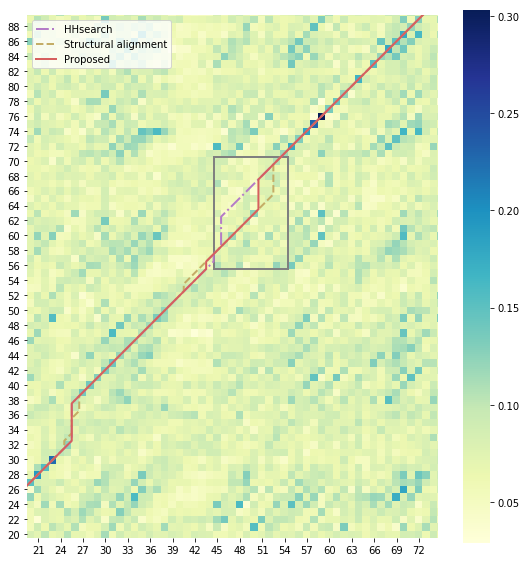

In [1]:
%matplotlib inline

from pathlib import Path
import random

import numpy as np
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.AlignIO import MultipleSeqAlignment

pal = [
    (0.2823529411764706, 0.47058823529411764, 0.8117647058823529), # PSI
    (0.41568627450980394, 0.8, 0.396078431372549), # DELTA
    (0.7058823529411765, 0.48627450980392156, 0.7803921568627451), # HH
    (0.4666666666666667, 0.7450980392156863, 0.8588235294117647), # SW
    (0.8392156862745098, 0.37254901960784315, 0.37254901960784315), # Pro
    (0.7686274509803922, 0.6784313725490196, 0.4), # TM
]

def alignment_graph(alignment):
    assert len(alignment[0]) == len(alignment[1])
    x, y = [0], [0]
    for i in range(len(alignment[0])):
        if alignment[0][i] == '-':
            x.append(x[-1])
            y.append(y[-1] + 1)
        elif alignment[1][i] == '-':
            x.append(x[-1] + 1)
            y.append(y[-1])
        else:
            x.append(x[-1] + 1)
            y.append(y[-1] + 1)
    return np.array(x), np.array(y)

model_name = 'flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.1_nn1000'

# query_sid = 'd2dsta1'
# template_sid = 'd1imja_'
# labels = np.load(f'data/prediction/{model_name}/{query_sid}/{template_sid}.npy')
# fig, ax = pyplot.subplots(figsize=(labels.shape[0]/10, labels.shape[1]/10))
# #sns.set_style('whitegrid')
# sns.set_context('talk')
# sns.heatmap(labels.T, ax=ax, linewidths=0, square=True, cbar_kws={"shrink": 0.5}, rasterized=True).invert_yaxis()

# index = list(SeqIO.parse(f'data/.hhsearch/{query_sid}/{template_sid}.pir', 'pir'))
# index[0].seq = Seq('-----' + str(index[0].seq), index[0].seq.alphabet)
# index[1].seq = Seq('AASVE' + str(index[1].seq), index[1].seq.alphabet)
# [print(_.seq) for _ in index]
# print('')
# ali = MultipleSeqAlignment(index)
# x, y = alignment_graph(ali)
# ax.plot(x, y, alpha=0.6, label='HHsearch', linewidth=3, linestyle='dashdot')

# index = list(SeqIO.parse(f'data/.tmalign_aln/{query_sid}/{template_sid}.pir', 'pir'))
# [print(_.seq) for _ in index]
# print('')
# ali = MultipleSeqAlignment(index)
# x, y = alignment_graph(ali)
# ax.plot(x, y, alpha=0.8, label='Structural alignment', linewidth=3, linestyle='dashed')

# index = list(SeqIO.parse(f'data/prediction/{model_name}/blosum62_off_open25_ext9/{query_sid}/{template_sid}.pir', 'pir'))
# [print(_.seq) for _ in index]
# ali = MultipleSeqAlignment(index)
# x, y = alignment_graph(ali)
# ax.plot(x, y, alpha=0.5, label='Proposed', linewidth=3)

# ax.legend()
# fig.savefig(Path(f'~/alignment_path_{query_sid}_{template_sid}.pdf').expanduser())

query_sid = 'd1qg3a1'
template_sid = 'd1va9a1'
labels = np.load(f'data/prediction/{model_name}/{query_sid}/{template_sid}.npy')
fig, ax = pyplot.subplots(figsize=(labels.shape[0]/10, labels.shape[1]/10))
#sns.set_context('paper')
sns.heatmap(labels.T, ax=ax, linewidths=0, square=True, rasterized=True, cmap="YlGnBu", cbar_kws={"shrink": 0.9}).invert_yaxis()

index = list(SeqIO.parse(f'data/.hhsearch/{query_sid}/{template_sid}.pir', 'pir'))
index[0].seq = Seq('-------' + str(index[0].seq), index[0].seq.alphabet)
index[1].seq = Seq('ISTEEAA' + str(index[1].seq), index[1].seq.alphabet)
[print(_.seq) for _ in index]
print('')
ali = MultipleSeqAlignment(index)
x, y = alignment_graph(ali)
ax.plot(x, y, alpha=1, label='HHsearch', linewidth=2, linestyle='dashdot', color=pal[2])

index = list(SeqIO.parse(f'data/.tmalign_aln/{query_sid}/{template_sid}.pir', 'pir'))
[print(_.seq) for _ in index]
print('')
ali = MultipleSeqAlignment(index)
x, y = alignment_graph(ali)
ax.plot(x, y, alpha=1, label='Structural alignment', linewidth=2, linestyle='dashed', color=pal[5])

index = list(SeqIO.parse(f'results/{model_name}/open0.1extend0.01/{query_sid}/{template_sid}.pir', 'pir'))
[print(_.seq) for _ in index]
print('')
ali = MultipleSeqAlignment(index)
x, y = alignment_graph(ali)
ax.plot(x, y, alpha=1, label='Proposed', linewidth=2, color=pal[4])

ax.add_patch(pyplot.Rectangle((45, 56), 10, 15, fill=False, color='gray', linewidth=2))

ax.set_xlim(20, 75)
ax.set_ylim(20, 90)
ax.legend(frameon=True)
fig.savefig(Path(f'~/alignment_path_{query_sid}_{template_sid}.pdf').expanduser(), bbox_inches='tight', pad_inches=0)

# query_sid = 'd1wzca1'
# template_sid = 'd1y8aa1'
# labels = np.load(f'data/prediction/{model_name}/{query_sid}/{template_sid}.npy')
# fig, ax = pyplot.subplots(figsize=(labels.shape[0]/20, labels.shape[1]/20))
# #sns.set_style('whitegrid')
# sns.set_context('talk')
# sns.heatmap(labels.T, ax=ax, linewidths=0, square=True, cbar_kws={"shrink": 0.5}, rasterized=True).invert_yaxis()

# suffix = 'ERKERAFEVLSAVSIPETEIYIMENSDFGEVLEKSKRMRVRLRGLAGELG'
# index = list(SeqIO.parse(f'data/.hhsearch/{query_sid}/{template_sid}.pir', 'pir'))
# index[0].seq = Seq('MIR' + str(index[0].seq) + '-'*len(suffix), index[0].seq.alphabet)
# index[1].seq = Seq('---' + str(index[1].seq) + suffix, index[1].seq.alphabet)
# [print(_.seq) for _ in index]
# print('')
# ali = MultipleSeqAlignment(index)
# x, y = alignment_graph(ali)
# ax.plot(x, y, alpha=0.7, label='HHsearch', linewidth=2, linestyle='dashdot')

# index = list(SeqIO.parse(f'data/.tmalign_aln/{query_sid}/{template_sid}.pir', 'pir'))
# [print(_.seq) for _ in index]
# ali = MultipleSeqAlignment(index)
# x, y = alignment_graph(ali)
# ax.plot(x, y, alpha=0.7, label='Structural alignment', linewidth=2, linestyle='dashed')

# index = list(SeqIO.parse(f'data/prediction/{model_name}/blosum62_off_open25_ext9/{query_sid}/{template_sid}.pir', 'pir'))
# [print(_.seq) for _ in index]
# print('')
# ali = MultipleSeqAlignment(index)
# x, y = alignment_graph(ali)
# ax.plot(x, y, alpha=0.5, label='Proposed', linewidth=2)

# ax.legend()

# fig.savefig(Path(f'~/alignment_path_{query_sid}_{template_sid}.pdf').expanduser())

In [4]:
from pathlib import Path

import pandas
from IPython.display import display

from machina.TMtoolsCommandLine import TMalignCommandLine

result_d = {}
result_d['Proposed'] = []
for pdb in Path('results/flann19_scop40_logscore_tmscore50_w5_randomsampling_ratio0.1_nn1000/open0.1extend0.01/d2axto1/').glob('*.pdb'):
    pdbid = pdb.stem
    tmalign = TMalignCommandLine(pdb, f'data/scop_e/{pdbid[2:4]}/{pdbid}.ent')
    tmalign.run()
    result_d['Proposed'].append(tmalign.tmscore[0])
result_d['SW'] = []
for pdb in Path('data/.sw_aln/open11_extend1/d2axto1/').glob('*.pdb'):
    pdbid = pdb.stem
    tmalign = TMalignCommandLine(pdb, f'data/scop_e/{pdbid[2:4]}/{pdbid}.ent')
    tmalign.run()
    result_d['SW'].append(tmalign.tmscore[0])
result_d['PSI'] = []
for pdb in Path('data/.psiblast_pssm_aln/d2axto1/').glob('*.pdb'):
    pdbid = pdb.stem
    tmalign = TMalignCommandLine(pdb, f'data/scop_e/{pdbid[2:4]}/{pdbid}.ent')
    tmalign.run()
    result_d['PSI'].append(tmalign.tmscore[0])
result_d['DELTA'] = []
for pdb in Path('data/.deltablast_aln/d2axto1/').glob('*.pdb'):
    pdbid = pdb.stem
    tmalign = TMalignCommandLine(pdb, f'data/scop_e/{pdbid[2:4]}/{pdbid}.ent')
    tmalign.run()
    result_d['DELTA'].append(tmalign.tmscore[0])
result_d['HHSearch'] = []
for pdb in Path('data/.hhsearch/d2axto1/').glob('*.pdb'):
    pdbid = pdb.stem
    tmalign = TMalignCommandLine(pdb, f'data/scop_e/{pdbid[2:4]}/{pdbid}.ent')
    tmalign.run()
    if tmalign.tmscore is None:
        tmalign = TMalignCommandLine(pdb, f'data/scop_e_all/{pdbid[2:4]}/{pdbid}.ent')
        tmalign.run()
        result_d['HHSearch'].append(tmalign.tmscore[0])
    else:
        result_d['HHSearch'].append(tmalign.tmscore[0])

result_df = pandas.DataFrame.from_dict(result_d, orient='index').transpose()
display(result_df['Proposed'])
display(result_df.describe())


0    0.62376
1    0.56644
2    0.51117
3    0.57373
4    0.60523
Name: Proposed, dtype: float64

,Proposed,SW,PSI,DELTA,HHSearch
count,5.000000,5.000000,3.000000,4.000000,3.000000
mean,0.576066,0.522628,0.439220,0.346375,0.368233
std,0.043113,0.088819,0.047385,0.091660,0.148852
min,0.511170,0.380180,0.400720,0.220300,0.253630
25%,0.566440,0.511610,0.412760,0.325202,0.284115
50%,0.573730,0.541670,0.424800,0.362580,0.314600
75%,0.605230,0.560300,0.458470,0.383752,0.425535
max,0.623760,0.619380,0.492140,0.440040,0.536470
